## TODO: сделать векторизацию + GRU

In [1]:
import pandas as pd
import time
import math
import os
import string
import logging
import numpy as np
import torch.tensor
import random
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable

import nltk
import gensim

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

from data_reader import read_data
from data_preprocessing import preprocess_data
from feature_extractor import extract_features

C:\Users\user\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
data = read_data()
data = preprocess_data(data, limit=10000)
data.head()

,id,Title,Uri,PublicationDateTimeUTC,ProcedureDisplayName,Amount,RubPrice,CurrencyCode,StatusDisplayName,StatusCode,SuppliersCount,IsWinner,Inn,Kpp,Name,Ogrn,ResultClass,Ogrn1
0,0100600000117000008,услуги по капитальному ремонту,https://zakupki.kontur.ru/0100600000117000008,2017-07-27,Закупка у единственного поставщика (подрядчика...,352000.00,352000.00,RUB,Размещение отменено,3.0,0.0,0.0,4720008346,NaN,МЕСТНАЯ АДМИНИСТРАЦИЯ МУНИЦИПАЛЬНОГО ОБРАЗОВАН...,1024702184451,2.0,47
1,0101100000116000162,Масло сладко-сливочное несоленое Крестьянское,https://zakupki.kontur.ru/0101100000116000162,2016-10-24,Электронный аукцион,3855260.00,3855260.00,RUB,Размещение отменено,3.0,0.0,0.0,0275006455,NaN,УПРАВЛЕНИЕ ФЕДЕРАЛЬНОЙ СЛУЖБЫ ИСПОЛНЕНИЯ НАКАЗ...,1020202776714,2.0,2
2,0101100000117000153,Индивидуальный рацион питания для повседневной...,https://zakupki.kontur.ru/0101100000117000153,2017-09-25,Электронный аукцион,3600000.00,3600000.00,RUB,Размещение отменено,3.0,0.0,0.0,0275006455,NaN,УПРАВЛЕНИЕ ФЕДЕРАЛЬНОЙ СЛУЖБЫ ИСПОЛНЕНИЯ НАКАЗ...,1020202776714,2.0,2
3,0101100000117000154,Консервы мясные,https://zakupki.kontur.ru/0101100000117000154,2017-09-25,Электронный аукцион,15400000.00,15400000.00,RUB,Размещение отменено,3.0,0.0,0.0,0275006455,NaN,УПРАВЛЕНИЕ ФЕДЕРАЛЬНОЙ СЛУЖБЫ ИСПОЛНЕНИЯ НАКАЗ...,1020202776714,2.0,2
4,0101100000416000025,Право заключения государственного контракта на...,https://zakupki.kontur.ru/0101100000416000025,2016-05-30,Открытый конкурс,79196.94,79196.94,RUB,Размещение отменено,3.0,0.0,0.0,0278103383,NaN,УПРАВЛЕНИЕ ФЕДЕРАЛЬНОЙ СЛУЖБЫ ПО НАДЗОРУ В СФЕ...,1040204605154,2.0,2


In [3]:
text_columns = ["Title", "Name"]
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

In [4]:
categorical_columns = ["ProcedureDisplayName", "CurrencyCode", "Ogrn1"]
categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

cat = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
# vals = data[numerical_columns[0]].map(float).values
# cat.append(vals.reshape(len(vals), 1))
# data['Categorical'] = np.concatenate(cat)
df = pd.DataFrame(cat, columns=list('abcdefghijklmnopqr'))
data = pd.concat([data, df], axis=1)

In [5]:
data.columns

Index(['id', 'Title', 'Uri', 'PublicationDateTimeUTC', 'ProcedureDisplayName',
       'Amount', 'RubPrice', 'CurrencyCode', 'StatusDisplayName', 'StatusCode',
       'SuppliersCount', 'IsWinner', 'Inn', 'Kpp', 'Name', 'Ogrn',
       'ResultClass', 'Ogrn1', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i',
       'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r'],
      dtype='object')

In [6]:
features = extract_features(data, onehot_encode=True)[0]

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used

oh CurrencyCode
oh ProcedureDisplayName
oh Ogrn
ng Title
ng ProcedureDisplayName
ng OrgName


In [7]:
features.head()

,RubPrice,ResultClass,SuppliersCount,Amount,OneHot_CurrencyCode_RUB,OneHot_ProcedureDisplayName_Закрытый аукцион,OneHot_ProcedureDisplayName_Закрытый конкурс,"OneHot_ProcedureDisplayName_Закупка у единственного поставщика (подрядчика, исполнителя)","OneHot_ProcedureDisplayName_Закупка у единственного поставщика (подрядчика, исполнителя) с учетом положений ст. 111 Закона № 44-ФЗ",OneHot_ProcedureDisplayName_Запрос котировок,...,Ngrams_Name_290,Ngrams_Name_291,Ngrams_Name_292,Ngrams_Name_293,Ngrams_Name_294,Ngrams_Name_295,Ngrams_Name_296,Ngrams_Name_297,Ngrams_Name_298,Ngrams_Name_299
0,352000.00,2.0,0.0,352000.00,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3855260.00,2.0,0.0,3855260.00,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3600000.00,2.0,0.0,3600000.00,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,15400000.00,2.0,0.0,15400000.00,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,79196.94,2.0,0.0,79196.94,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
features['target'] = [int(x) for x in features['ResultClass']]
features = features.drop(['SuppliersCount', 'ResultClass', 'RubPrice'], axis=1)

**First, a bunch of functions**

In [9]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def train_validate_test_split(df, train_percent=0.6, validate_percent=0.2, seed=666):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    #print('We found %s lines of data' % m)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, test, validate


def makeBatch(batch_size, data):
    """
    :param batch_size: nr of examples in bach
    :return: a padded tensor of size [hh*batch_size*L]
    """
    indices = random.sample(list(data.index), batch_size)
    X_batch = data.drop(['target'], axis=1).loc[indices]
    X_tensor = torch.FloatTensor(X_batch.values)

    y_batch = data['target'].loc[indices]
    y_tensor = torch.LongTensor(y_batch.values)
    
    return X_tensor, y_tensor

**And then, some arguments**


In [10]:

class Params():
    def __init__(self):
        self.batch_size = 32
        self.hidden_size = 32
        self.embedding_size = 64
        self.epochs = 50
        self.nr_classes = 3
        self.gpu = False
        self.learning_rate = 0.001
        self.train_ratio = 0.8
        self.val_ratio = 0.1
        self.test_ratio = 1-self.val_ratio-self.train_ratio
        self.n_layers = 2
        self.dropout = 0.1

Args = Params()

**Model**

In [11]:
class NN_classifier(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        size1 = 512
        size2 = 128
        size3 = 32
        size4 = 8
        self.model = nn.Sequential(
#             nn.LSTM(input_size, 100, 3),
#             nn.GRU(input_size, 100, 3)
            nn.Linear(input_size, size1),
            nn.ReLU(),
            nn.BatchNorm1d(size1),
            nn.Linear(size1, size2),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.BatchNorm1d(size2),
            nn.Linear(size2, size3),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.BatchNorm1d(size3),
            nn.Linear(size3, size4),
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.BatchNorm1d(size4),
            nn.Linear(size4, output_size),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, inputs):
        return self.model(inputs)

In [12]:
class LSTM_classifier(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers, dropout, embed_size):
        super().__init__()

        self.input_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.embed_size = embed_size
        self.embedding = nn.Embedding(self.input_size, self.embed_size)
        self.rnn = nn.LSTM(input_size=self.embed_size,
                           hidden_size=hidden_size,
                           dropout=dropout,
                           num_layers=n_layers, bidirectional=True)
        self.hidden2label = nn.Linear(2*hidden_size, 2)
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropoutLayer = nn.Dropout()

    def init_hidden(self, batch_size):
        h0 = Variable(torch.zeros(self.n_layers*2, batch_size, self.hidden_size))
        c0 = Variable(torch.zeros(self.n_layers*2, batch_size, self.hidden_size))
        return h0, c0

    def forward(self, inputs):
        print(self.input_size)
        print(inputs)
        print(inputs.size(-1))
        self.hidden = self.init_hidden(inputs.shape[0])
#         embedded = self.embedding(inputs)  # antal i batch * max ord längd * Embedding_dim
        outputs, self.hidden = self.rnn(inputs, self.hidden)
        output, output_lengths = pad_packed_sequence(outputs, batch_first=False)
        #print(output.size())
        output = torch.transpose(output, 0, 1)
        #print(output.size())
        output = torch.transpose(output, 1, 2)
        #print(output.size())
        output = torch.tanh(output)
        #print(output.size())
        output, indices = F.max_pool1d(output,output.size(2), return_indices=True)
        #print(output.size())
        output = torch.tanh(output)
        output = output.squeeze(2)
        output = self.dropoutLayer(output)
        #print(output.size())
        output = self.hidden2label(output)
        #print(output.size())
        output = self.softmax(output)
        return output, self.hidden

**The start of the code itself, along with initalization of the model**


In [15]:
n_categories = 3

train_data, val_data, test_data = train_validate_test_split(features,seed=333)

# model = LSTM_classifier(vocab_size = features.shape[0], 
#                         hidden_size = Args.hidden_size, 
#                         n_layers = Args.n_layers, 
#                         dropout = Args.dropout,
#                         embed_size = Args.embedding_size)

model = NN_classifier(934, 3)

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

def train(input_tensor, target_tensor):
#     model.hidden = model.init_hidden(Args.batch_size) 
    model.zero_grad()
    output = model.forward(input_tensor)
    loss = criterion(output, target_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()

**Begin training **

In [16]:
current_loss = 0

all_losses = []
val_acc = []
train_acc = []
predictions = []
labels = []
print_every = int(len(train_data)/Args.batch_size) #every epoch
n_iters  = int(len(train_data)/Args.batch_size*Args.epochs)
plot_every = print_every
start = time.time()


for iter in range(n_iters):
    input_tensor, target_tensor = makeBatch(batch_size=Args.batch_size, data=train_data)
    output, loss = train(input_tensor=input_tensor, target_tensor=target_tensor)
    current_loss += loss
    predictions.extend(list(torch.argmax(output, dim=1).numpy()))
    labels.extend(list(target_tensor.numpy()))
    # Print iter number, loss, name and guess`
    if (iter) % print_every == 0:
        corrects = 0
        corrects_train = 0
        input_tensor, target_tensor = makeBatch(batch_size=len(val_data), data=val_data)
        
        output = model(inputs=input_tensor)
        preds = torch.argmax(output, dim=1)
        for i in range(len(preds)):
            if preds[i] == target_tensor[i]:
                corrects += 1
        
        for i in range(len(labels)):
            if labels[i] == predictions[i]:
                corrects_train +=1
        
        
        accuracy = corrects / len(preds)
        train_accuracy = corrects_train / len(labels)
        
        val_acc.append(accuracy)
        train_acc.append(train_accuracy)
        labels = []
        predictions =[]
        print('Val acc after {} epochs is: {}. train acc: {}. time elapsed: {}. avg train loss: {}'
              .format(int(iter/print_every+1), round(accuracy, 2), round(train_accuracy,2), timeSince(start), round(loss, 2)))

        
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0 

Val acc after 1 epochs is: 0.35. train acc: 0.31. time elapsed: 0m 0s. avg train loss: 1.05
Val acc after 2 epochs is: 0.38. train acc: 0.45. time elapsed: 0m 18s. avg train loss: 1.11
Val acc after 3 epochs is: 0.4. train acc: 0.48. time elapsed: 0m 36s. avg train loss: 0.96


KeyboardInterrupt: 

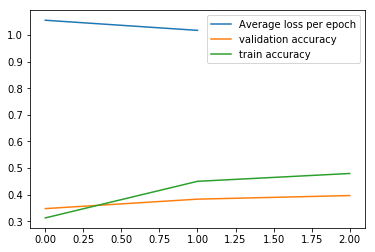

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses[1:])
plt.plot(val_acc[:])
plt.plot(train_acc[:])
plt.legend(['Average loss per epoch','validation accuracy','train accuracy'])